# 08. PyTorch Paper Replicating.

**The goal of machine learning research paper replicating is: turn a ML research paper into usuable code.**

In this notebook, I am going to be replicating the Vision Transformer (ViT) [architecture/paper](https://arxiv.org/abs/2010.11929) with PyTorch.


This notebook is fully followed from the greatest [course](https://zerotomastery.io/courses/learn-pytorch/) by [Daniel Bourke](https://www.linkedin.com/in/mrdbourke/)

The Book version of the course is [here](https://www.learnpytorch.io/08_pytorch_paper_replicating/)


# Get Setup

Now I am going to import the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchmetrics import Accuracy

try:
    from torchinfo import summary
except:
    print(f"[INFO] Couldn't find the torchinfo...\n Installing it.....")
    !pip install -qq torchinfo
    from torchinfo import summary

# Try to import going_moduler directory. download it from GitHub, if it doesn't work
try:
    print(f"[INFO] Trying to find the going_modular directory.....")
    from going_modular import data_setup, engine, utils
except:
    print(f"[INFO] Couldn't find the directory...\n Downloading it from github.....")
    !git clone https://github.com/Niloy009/learning_pytorch.git
    !mv leaning_pytorch/going_modular .
    !rm -rf learning_pytorch
    from going_modular import data_setup, engine, utils




[INFO] Trying to find the going_modular directory.....


In [2]:
# Setup device agnostic code

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

# Get the Data

Download the data if not exist and unzip it.

In [3]:
import os
from pathlib import Path
import zipfile
import requests

def download_data(source: str, destination: str, remove_source: bool= True) -> Path:
    """Download a ziped dataset from source and unzip to destination

    Args:
        source: The source path where the data will download from.
        destination: The destination path where the data will download and unzip to.
        remove_source: Whether the source remove or not after download.
        
    Returns:
        pathlib.Path to downloaded data.
    """

    # Setup the data path
    data_path = Path("data/")
    image_path = data_path / destination

    # If image folder is not exist, then prepare it and download the data
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping re-download")
    else:
        print(f"[INFO] {image_path} doesn't exist. Downloading it.....")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download the data..
        target_file = Path(source).name
        with open(file=data_path / target_file , mode='wb') as file:
            request = requests.get(url=source)
            print(f"[INFO] Downloading {target_file} from {source}.....")
            file.write(request.content)
            
        # Unzip the folder
        with zipfile.ZipFile(data_path / target_file, mode='r') as zip_ref:
            print(f"[INFO] Unzipping {target_file} file......")
            zip_ref.extractall(path=image_path)

        # Remove the zip folder
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path


In [4]:
image_data_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", 
              destination="pizza_steak_sushi")
image_data_path

[INFO] data/pizza_steak_sushi directory exists, skipping re-download


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_data_path / 'train'
test_dir = image_data_path / 'test'

In [6]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Create Datasets and DataLoaders

In [7]:
# Create image size (from table 3 on ViT paper)
IMAGE_SIZE = 224

# Create transforms pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])
print(f"manually created transforms: {manual_transforms}")


manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
# Create batch size (the paper used 4096 but I am stick with 32 to start with small)
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=BATCH_SIZE)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

# Visualize a single image

In [9]:
# Get a batch of images
image_batch, label_bacth = next(iter(train_dataloader))

# Get the single image and label
image , label = image_batch[0], label_bacth[0]

# Get the shape of the image and label
image.shape, label

/Users/niloy_saha/anaconda3/envs/torch/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([3, 224, 224]), tensor(2))

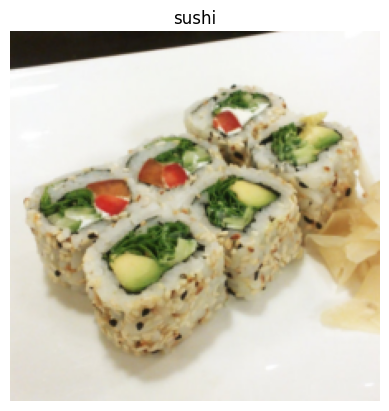

In [10]:
# Plot the image and its label
plt.imshow(image.permute(1,2,0)) # color_channel, height, width -> height, width, color_channel
plt.title(class_names[label])
plt.axis(False);


# Replicating ViT: Overview

Looking at a whole machine learning research paper can be imtimidating.

So in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs** - What goes into the model? (in this case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case. we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function. (i.e. could be self-attention)
* **Blocks** - A collection of layers
* **Model** - A collection of blocks
